In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [5]:
# USING THE AUGMENTATION DATASET ONLY? OR ORIGINAL INCLUDED?
dataset = np.load(r'data/images/augmented/augmentation.npy', allow_pickle=True)

images = []
labels = []

for idx, d in enumerate(dataset):
    images.extend(d)
    for e in d:
        labels.append([idx])
        
images = np.array(images)
labels = np.array(labels)

In [6]:
image_shape = images.shape

BATCH_SIZE = 16
IMG_SIZE = image_shape[1:3]
IMG_SHAPE = image_shape[1:4]

print("Found", image_shape[0], "images of shape", IMG_SHAPE)

Found 299619 images of shape (32, 32, 3)


In [8]:
X_trainval, X_test, y_trainval, y_test = train_test_split(images,
                                                    labels,
                                                    test_size=0.15)#,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                    y_trainval,
                                                    test_size=0.3)#,random_state=42)

print(f"Randomly splitting the dataset into {len(y_train)} test images, {len(y_val)} validation images, and {len(y_test)} test images.")

Randomly splitting the dataset into 178273 test images, 76403 validation images, and 44943 test images.


In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [18]:
base_model.trainable = False

In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [21]:
prediction_layer = tf.keras.layers.Dense(4)

In [22]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.cast(inputs, tf.float32)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.cast (TFOpLambda)        (None, 32, 32, 3)         0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 32, 32, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 32, 32, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                             

In [25]:
len(model.trainable_variables)

2

In [26]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(x=X_val, y=y_val, batch_size=BATCH_SIZE)#validation_dataset)

4776/4776 [==============================] - 50s 10ms/step - loss: 1.3698 - accuracy: 0.3613


In [27]:
print(f"Initial loss: {loss0:.2f}")
print(f"Initial accuracy: {accuracy0:.2f}")

Initial loss: 1.37
Initial accuracy: 0.36


In [29]:
history = model.fit(x=X_train, 
                    y=y_train,
                    batch_size=BATCH_SIZE,
                    epochs=initial_epochs,
                    validation_data=(X_val, y_val))

Epoch 1/15
11143/11143 [==============================] - 171s 15ms/step - loss: 1.2316 - accuracy: 0.4808 - val_loss: 1.1861 - val_accuracy: 0.4889
Epoch 2/15
11143/11143 [==============================] - 167s 15ms/step - loss: 1.1744 - accuracy: 0.4932 - val_loss: 1.1644 - val_accuracy: 0.4967
Epoch 3/15
11143/11143 [==============================] - 168s 15ms/step - loss: 1.1624 - accuracy: 0.4972 - val_loss: 1.1566 - val_accuracy: 0.5000
Epoch 4/15
11143/11143 [==============================] - 167s 15ms/step - loss: 1.1581 - accuracy: 0.4989 - val_loss: 1.1528 - val_accuracy: 0.5009
Epoch 5/15
11143/11143 [==============================] - 171s 15ms/step - loss: 1.1553 - accuracy: 0.5008 - val_loss: 1.1500 - val_accuracy: 0.5028
Epoch 6/15
11143/11143 [==============================] - 161s 14ms/step - loss: 1.1533 - accuracy: 0.5021 - val_loss: 1.1480 - val_accuracy: 0.5034
Epoch 7/15
11143/11143 [==============================] - 162s 15ms/step - loss: 1.1522 - accuracy: 0.5019

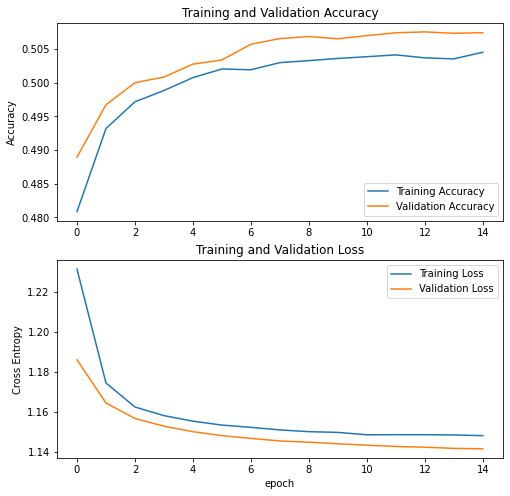

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()